In [2]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import  MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# **Data Augmentation Pipeline And Dataset Info :**

In [4]:
def data_aug(train_dir, val_dir, test_dir, validation_split=0.0):
    
    # Check the directories are exist or not 
    for dir in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir):
            print(f"Warning: No directory [{dir}] is found.")
    
    # Define data augmentation pipeline 
    train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input, 
                                       rotation_range=25,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True,
                                       zoom_range=0.2,
                                       brightness_range=[0.8,1.2],
                                       shear_range=0.15,
                                       fill_mode='nearest',
                                       validation_split=validation_split if not val_dir else 0.0)
    
    val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
                                     validation_split=validation_split if not val_dir else 0.0)
    
    # Create data generators based on available directories
    if val_dir and test_dir:
        try:
            train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
            print("Successfully created Train Generator.")
        except Exception as e:
            print(f"Error occurred during create Train Generator: {e}")
        
        try:
            val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
            print("Successfully created Validation Generator.")
        except Exception as e:
            print(f"Error occurred during create Validation Generator: {e}")
        
        try:
            test_gen = val_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
            print("Successfully created Test Generator.")
        except Exception as e:
            print(f"Error occurred during create Test Generator: {e}")
    
    else:
        try:
            train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True, subset='training')
            print("Successfully created Train Generator.")
        except Exception as e:
            print(f"Error occurred during create Train Generator: {e}")
        
        try:
            val_gen = val_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True, subset='validation')
            print("Successfully created Validation Generator.")
        except Exception as e:
            print(f"Error occurred during create Validation Generator: {e}")
        
        try:
            # Use validation set as test set if no separate test set 
            test_gen = val_gen
            print("Successfully created Test Generator.")
        except Exception as e:
            print(f"Error occurred during create Test Generator: {e}")
    
    return train_gen , val_gen, test_gen

In [5]:
train_gen , val_gen, test_gen = data_aug(train_dir='/kaggle/input/skin-diseases-splited-dataset/train', 
                                         val_dir='/kaggle/input/skin-diseases-splited-dataset/val', 
                                         test_dir='/kaggle/input/skin-diseases-splited-dataset/val', 
                                         validation_split=0.0)

Found 1640 images belonging to 6 classes.
Successfully created Train Generator.
Found 620 images belonging to 6 classes.
Successfully created Validation Generator.
Found 620 images belonging to 6 classes.
Successfully created Test Generator.


#### **Dataset Information :**

In [6]:
print(f"Training samples: [{train_gen.samples}]")
print(f"Validation samples: [{val_gen.samples}]")
print(f"Test samples: [{test_gen.samples}]")
print(f"Number of classes: [{len(train_gen.class_indices)}]")
print(f"Class names: {list(train_gen.class_indices.keys())}")

Training samples: [1640]
Validation samples: [620]
Test samples: [620]
Number of classes: [6]
Class names: ['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


#### **Plot Function To See Class Distributions :** 

In [7]:
def cls_dis(any_generator, set_name):
     
    cls_counts = np.bincount(any_generator.classes) 
    cls_labels = list(any_generator.class_indices.keys())
    
    plt.figure(figsize=(10,5))
    bars = plt.bar(cls_labels, cls_counts, color='Skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Class Distribution in {set_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Disease Classes', fontsize=12, fontweight='bold')  
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars 
    for bar, count in zip(bars, cls_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center',
                 va='bottom', fontweight='bold')  
    
    plt.tight_layout()
    plt.show()

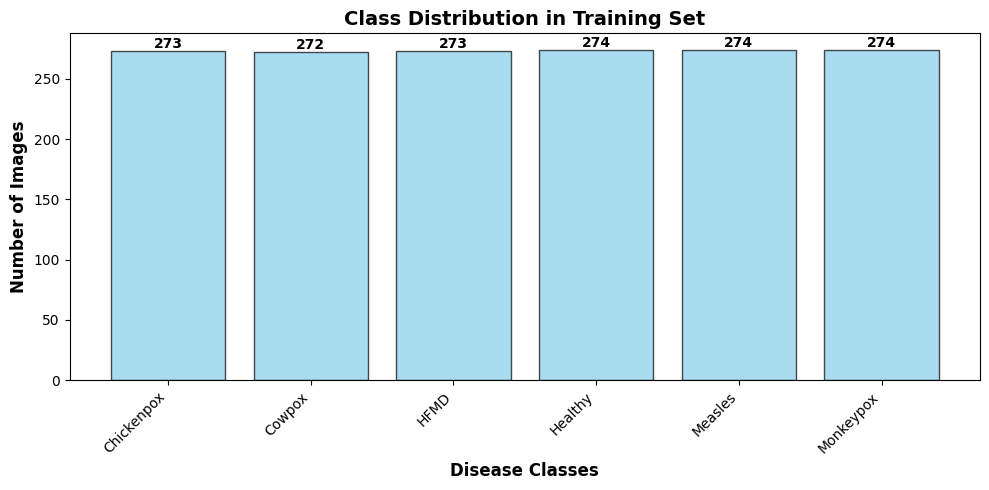

In [8]:
cls_dis(any_generator=train_gen, set_name='Training Set')

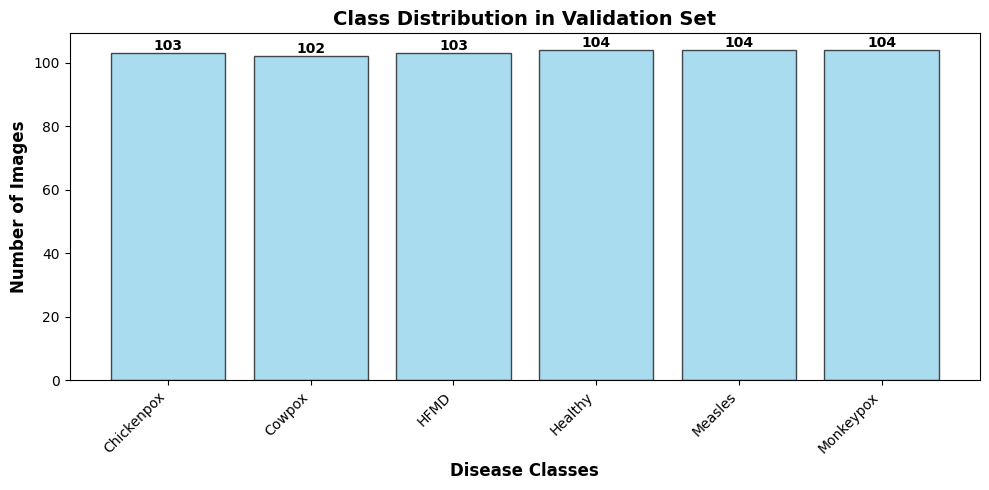

In [13]:
cls_dis(any_generator=val_gen, set_name='Validation Set')

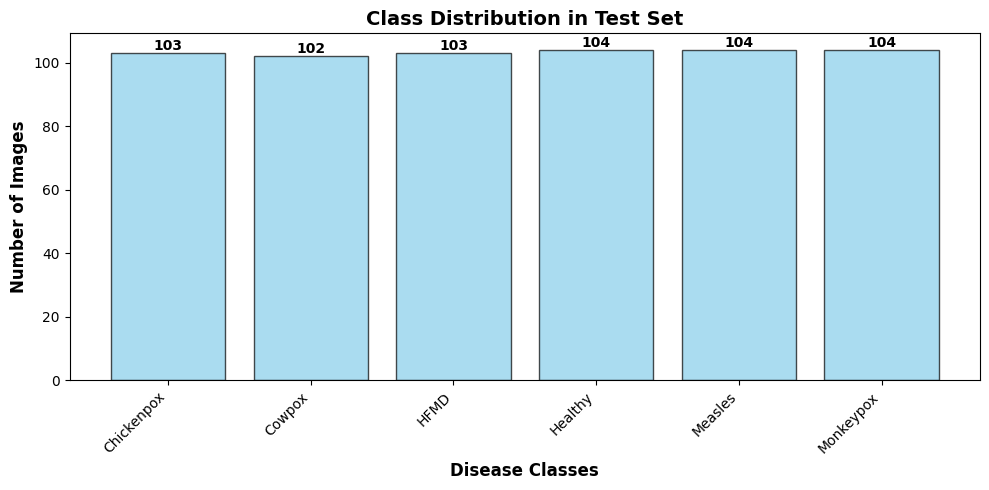

In [14]:
# We use val set as test set
cls_dis(any_generator=val_gen, set_name='Test Set')

# **Create The Model With 'MobileNetV2' Base And Custom Classification Head :**

In [9]:
def create_model():
    base_model = MobileNetV2(weights='imagenet',
                             include_top=False,
                             input_shape=(224,224,3))
    
    # Freeze the bas model layers (If we want transfer learning)
    base_model.trainable = False
    
    # Custom Classification Head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu', dtype='float32')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', dtype='float32')(x)
    # x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', dtype='float32')(x)
    # x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', dtype='float32')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(6, activation='softmax', dtype='float32', name='predictions')(x)    # Number of classes in the dataset is [6]
    
    new_model = Model(inputs=base_model.input, outputs=predictions)
    
    return new_model , base_model 

In [10]:
new_model , base_model = create_model()

2025-06-18 14:38:32.455506: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,264,646 (16.27 MB)

 Trainable params: 2,004,102 (7.65 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Compute Class Weights For Balanced Training :**
**N.B. Since we already blance our dataset we don't need to use class weights for balance the training.**

In [13]:
train_labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: [{class_weights_dict}]")

Class weights: [{0: 1.0012210012210012, 1: 1.0049019607843137, 2: 1.0012210012210012, 3: 0.9975669099756691, 4: 0.9975669099756691, 5: 0.9975669099756691}]


# **Transfer Learning With Frozen Base :**

In [14]:
def train_with_frozen_base(train_gen, val_gen, new_model, checkpoint_model_save_path, base_initial_lr, epochs_frozen, #class_weights
                           ):
    
    # Compile model for initial training 
    new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_initial_lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy',
                               tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall')])
    
    # Define callbacks
    callbacks = [EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
                 ModelCheckpoint(checkpoint_model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001, verbose=1)]
    
    print("\n" + "="*60)
    print("Phase-01: Training with frozen base...........")
    print(f"Initial Learning Rate: [{base_initial_lr}]")
    print(f"Epochs: [{epochs_frozen}]")
    print(f"Total Layers: [{len(new_model.layers)}]")
    print(f"Trainable Parameters: [{new_model.count_params()}]")
    # Count frozen vs trainable layers
    frozen_layers = sum(1 for layer in new_model.layers if not layer.trainable)
    trainable_layers = sum(1 for layer in new_model.layers if layer.trainable) 
    print(f"Frozen Layers: [{frozen_layers}], Trainable Layers: [{trainable_layers}]")
    print("="*60)
     
    # Fit the new model 
    try:
        history_frozen = new_model.fit(train_gen, validation_data=val_gen, epochs=epochs_frozen, callbacks=callbacks, #class_weight=class_weights
                                       verbose=1)
        print(f"\nPHASE-01: Training Completed Successfully!!!!\n")
    except Exception as e:
        print(f"\nWarning: PHASE-01: Training Failed With Error: {e}")
        print("Please Check Your Data Generators, Model Architecture And Parameters.")
        return None

    # For train summary
    print("="*60)
    print(f"Final Train Loss: [{history_frozen.history['loss'][-1]}]")
    print(f"Best Train Loss: [{min(history_frozen.history['loss'])}]")
    print(f"Final Train Accuracy: [{history_frozen.history['accuracy'][-1]}]")
    print(f"Best Train Accuracy: [{max(history_frozen.history['accuracy'])}]")
    print("="*60)
    
    # For validation summary
    print(f"Final Validation Loss: [{history_frozen.history['val_loss'][-1]}]")
    print(f"Best Validation Loss: [{min(history_frozen.history['val_loss'])}]")
    print(f"Final Validation Accuracy: [{history_frozen.history['val_accuracy'][-1]}]")
    print(f"Best Validation Accuracy: [{max(history_frozen.history['val_accuracy'])}]")
    print("="*60 + "\n")
    
    return history_frozen

In [15]:
history_frozen = train_with_frozen_base(train_gen=train_gen,
                       val_gen=val_gen, 
                       new_model=new_model,
                       checkpoint_model_save_path="/kaggle/working/transfer_learning_best.h5",
                       base_initial_lr=0.001,
                       epochs_frozen=200,
                       #class_weights=class_weights_dict
                       )


Phase-01: Training with frozen base...........
Initial Learning Rate: [0.001]
Epochs: [200]
Total Layers: [163]
Trainable Parameters: [4264646]
Frozen Layers: [154], Trainable Layers: [9]


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4773 - loss: 1.3917 - precision: 0.6297 - recall: 0.3299 - top_2_accuracy: 0.6771
Epoch 1: val_loss improved from inf to 0.53714, saving model to /kaggle/working/transfer_learning_best.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4799 - loss: 1.3849 - precision: 0.6319 - recall: 0.3333 - top_2_accuracy: 0.6793 - val_accuracy: 0.8452 - val_loss: 0.5371 - val_precision: 0.9160 - val_recall: 0.7387 - val_top_2_accuracy: 0.9516 - learning_rate: 0.0010
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7968 - loss: 0.5793 - precision: 0.8329 - recall: 0.7586 - top_2_accuracy: 0.9266
Epoch 2: val_loss improved from 0.53714 to 0.34984, saving model to /kaggle/working/transfer_learning_best.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7969 - loss: 0.5790 - precision: 0.8330 - recall: 0.7588 - top_2_accuracy: 0.9267 - val_accuracy: 0.8839 - val_loss: 0.3498 - val_precision: 0.9281 - val_recall: 0

#### **Check For Overfitting Or Underfitting :**

In [16]:
best_train_acc = max(history_frozen.history['accuracy'])
best_val_acc = max(history_frozen.history['val_accuracy'])
dif = best_train_acc - best_val_acc

if dif > 0.03:
    print(f"Warning: Large gap [{dif:.3f}] between train and validation accuracy suggests overfitting!!!.")
elif dif < -0.03:
    print(f"Warning: Large gap [{dif:.3f}] between train and validation accuracy suggests underfitting!!!.")
else:
    print(f"Good Fit: Gap between train and validation accuracy is [{dif:.3f}].")

Good Fit: Gap between train and validation accuracy is [-0.010].


# **Fine Tune By Unfreezing Top Layers :**

In [17]:
def train_by_unfreezing_top_layers(train_gen, val_gen, new_model, base_model, checkpoint_model_save_path, 
                                   final_model_save_path, fine_initial_lr, epochs_fine, #class_weights
                                  ):
    
    # Recompile model with lower learning rate
    new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_initial_lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy',
                               tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall')])
    
    # Define callbacks for fine tune
    callbacks = [EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
                 ModelCheckpoint(checkpoint_model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001, verbose=1)]
    
    # Fine tune by unfreezing top layers 
    base_model.trainable = True
    
    # Fine tune from this layer onwards
    fine_tune_at = len(base_model.layers) - 60 # We are unfreezing last 60 layers of base model from 154 layer.
    # fine_tune_at = 94 means [0-93] layers will be frozeen, and 94-154 layers will fine tune. 
    
    # Freeze all layers except the last few
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print("\n" + "="*60)
    print("Phase-02: Fine Tune By Unfreezing Top Layers ...........")
    print(f"Initial Learning Rate: [{fine_initial_lr}]")
    print(f"Epochs: [{epochs_fine}]")
    print(f"Total Layers: [{len(base_model.layers)}]")
    print(f"Trainable Parameters: [{sum([tf.keras.backend.count_params(w) for w in new_model.trainable_weights])}]") 
    print(f"Fine tune from layer [{fine_tune_at}] onwards.")
    print(f"Trainable layers [{sum(1 for layer in base_model.layers if layer.trainable) }]")
    print("="*60)
    
    # Fit the new model 
    try:
        history_fine_tune = new_model.fit(train_gen, validation_data=val_gen, epochs=epochs_fine, callbacks=callbacks, # class_weight=class_weights
                                       verbose=1)
        print(f"\nPHASE-02: Training Completed Successfully!!!!\n")
    except Exception as e:
        print(f"\nWarning: PHASE-02: Training Failed With Error: {e}")
        print("Please Check Your Data Generators, Model Architecture And Parameters.")
        return None

    # For train summary
    print("="*60)
    print(f"Final Train Loss: [{history_fine_tune.history['loss'][-1]}]")
    print(f"Best Train Loss: [{min(history_fine_tune.history['loss'])}]")
    print(f"Final Train Accuracy: [{history_fine_tune.history['accuracy'][-1]}]")
    print(f"Best Train Accuracy: [{max(history_fine_tune.history['accuracy'])}]")
    print("="*60)
    
    # For validation summary
    print(f"Final Validation Loss: [{history_fine_tune.history['val_loss'][-1]}]")
    print(f"Best Validation Loss: [{min(history_fine_tune.history['val_loss'])}]")
    print(f"Final Validation Accuracy: [{history_fine_tune.history['val_accuracy'][-1]}]")
    print(f"Best Validation Accuracy: [{max(history_fine_tune.history['val_accuracy'])}]")
    print("="*60 + "\n")
    
    # Save the final fine tune model
    new_model.save(os.path.join(final_model_save_path, 'final_fine_tune_best.h5'))
    
    return history_fine_tune 

In [18]:
history_fine_tune = train_by_unfreezing_top_layers(train_gen=train_gen,
                               val_gen=val_gen,
                               new_model=new_model,
                               base_model=base_model,
                               checkpoint_model_save_path="/kaggle/working/fine_tune_best.h5", 
                               final_model_save_path="/kaggle/working/", 
                               fine_initial_lr=0.0001,
                               epochs_fine=200, 
                               # class_weights=class_weights_dict
                               )


Phase-02: Fine Tune By Unfreezing Top Layers ...........
Initial Learning Rate: [0.0001]
Epochs: [200]
Total Layers: [154]
Trainable Parameters: [3959814]
Fine tune from layer [94] onwards.
Trainable layers [60]
Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8074 - loss: 0.6199 - precision: 0.8317 - recall: 0.7875 - top_2_accuracy: 0.9323
Epoch 1: val_loss improved from inf to 0.50490, saving model to /kaggle/working/fine_tune_best.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8081 - loss: 0.6174 - precision: 0.8324 - recall: 0.7883 - top_2_accuracy: 0.9327 - val_accuracy: 0.8629 - val_loss: 0.5049 - val_precision: 0.8748 - val_recall: 0.8565 - val_top_2_accuracy: 0.9677 - learning_rate: 1.0000e-04
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8929 - loss: 0.2942 - precision: 0.9052 - recall: 0.8819 - top_2_accuracy: 0.9803
Epoch 2: val_loss did not improve from 0.50490
52/52 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8928 - loss: 0.2

#### **Check For Overfitting Or Underfitting :**

In [19]:
best_train_acc = max(history_fine_tune.history['accuracy'])
best_val_acc = max(history_fine_tune.history['val_accuracy'])
dif = best_train_acc - best_val_acc

if dif > 0.03:
    print(f"Warning: Large gap [{dif:.3f}] between train and validation accuracy suggests overfitting!!!.")
elif dif < -0.03:
    print(f"Warning: Large gap [{dif:.3f}] between train and validation accuracy suggests underfitting!!!.")
else:
    print(f"Good Fit: Gap between train and validation accuracy is [{dif:.3f}].")

Good Fit: Gap between train and validation accuracy is [0.000].


# **Plot Training History :**

In [20]:
def training_history_plot(history_frozen, history_fine_tune, plot_save_path, save_plot_name):
    
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(1 , 2, figsize=(15,5))
    
    frozen_epochs = len(history_frozen.history['loss'])
    epochs = range(1, frozen_epochs + len(history_fine_tune.history['loss']) + 1)
        
    train_loss =  history_frozen.history['loss'] + history_fine_tune.history['loss']
    val_loss =  history_frozen.history['val_loss'] + history_fine_tune.history['val_loss']
    train_acc =  history_frozen.history['accuracy'] + history_fine_tune.history['accuracy']
    val_acc =  history_frozen.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
        
    for ax in axes.flat:
        ax.axvline(x=frozen_epochs, color='r', linestyle='--', alpha=0.7, label='Fine-Tuning-Starts')
        
    # Plot loss
    axes[0].plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss', fontsize=15, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss') 
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot accuracy
    axes[1].plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy', fontsize=15, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy') 
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_save_path, save_plot_name), dpi=300, bbox_inches='tight')
    plt.show()

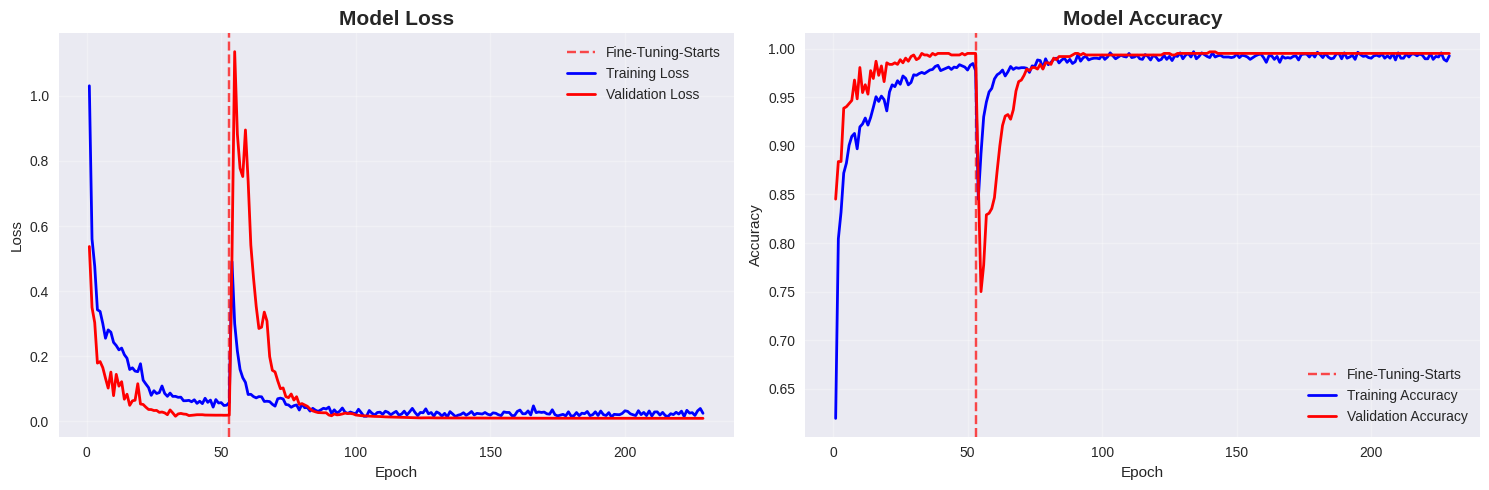

In [21]:
training_history_plot(history_frozen=history_frozen,
                      history_fine_tune=history_fine_tune,
                      plot_save_path='/kaggle/working/',
                      save_plot_name='frozen_and_fine_tune_traning_plot.png')

# **Model Evaluation :**

In [22]:
def evaluate_model_with_visualization(model, test_gen, eval_results_save_path):
    
    # Reset generator to start from beginning
    test_gen.reset()
    
    predictions = model.predict(test_gen, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes
    # Get class labels sorted by index  
    class_labels = [key for key, value in sorted(test_gen.class_indices.items(), key = lambda item: item[1])]
    
    # Plot or visualization "Confusion Matrix"
    con_mat = confusion_matrix(true_classes,  predicted_classes)
    plt.figure(figsize=(15,10))
    sns.heatmap(con_mat, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels, cbar_kws={'label': 'count'})
    plt.title('Confusion Matrix For Skin Disease Classification', fontsize=15, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(eval_results_save_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Classification report
    cl_report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
    print("\n" + "="*60)
    print("Classification Report")
    print("="*60)
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))
    
    # Plot or visualiztion Per class metrics
    met_df = []
    for i, class_name in enumerate(class_labels):
        precision = cl_report[class_name]['precision']
        recall = cl_report[class_name]['recall']
        f1_score = cl_report[class_name]['f1-score']
        support = cl_report[class_name]['support']
        met_df.append({'Class': class_name,
                       'Precision': precision,
                       'Recall': recall, 
                       'F1-Score': f1_score,
                       'Support': support})
        
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    
    classes = [m['Class'] for m in  met_df ] 
    precision_scores = [m['Precision'] for m in  met_df ] 
    recall_scores = [m['Recall'] for m in  met_df ]
    f1_scores = [m['F1-Score'] for m in  met_df ]
    
    # For precision
    axes[0].bar(classes, precision_scores, color='skyblue', alpha=0.7)
    axes[0].set_title('Precision By Class', fontweight='bold')
    axes[0].set_ylim(0,1)
    axes[0].tick_params(axis='x', rotation=45)    
    
    # For recall    
    axes[1].bar(classes, recall_scores, color='blue', alpha=0.7)
    axes[1].set_title('Recall By Class', fontweight='bold')
    axes[1].set_ylim(0,1)
    axes[1].tick_params(axis='x', rotation=45) 
    
    # For f1 score   
    axes[2].bar(classes, f1_scores, color='lightgreen', alpha=0.7)
    axes[2].set_title('F1-Score By Class', fontweight='bold')
    axes[2].set_ylim(0,1)
    axes[2].tick_params(axis='x', rotation=45) 
    
    plt.tight_layout()
    plt.savefig(os.path.join(eval_results_save_path, 'class_metrics.png'), dpi=300, bbox_inches='tight')
    plt.show() 
    
    return cl_report, con_mat

#### **Plot Sample Predictions With True And Predicted Labels :**

In [23]:
def plot_prediction_samples(model, test_gen, batch_images, samples_results_save_path, num_samples, no_subplot_x_axes, no_subplot_y_axes):
    
    # Reset generator to start from beginning
    test_gen.reset()
    
    # Get a batch of test images
    batch_images, batch_labels = next(test_gen)
    predictions = model.predict(batch_images)  
    # Get class labels sorted by index   
    class_labels = [key for key, value in sorted(test_gen.class_indices.items(), key = lambda item: item[1])]
    
    
    # Calculate grid size based on num_samples if not specified
    total_subplots = no_subplot_x_axes * no_subplot_y_axes
    if num_samples > total_subplots:
        print(f"Warning: num_samples [{num_samples}] exceeds subplot grid size [{total_subplots}]. Using [{total_subplots}] samples.")
        num_samples = total_subplots
    
    # Plot samples
    fig, axes = plt.subplots(no_subplot_x_axes, no_subplot_y_axes, figsize=(12,12))
    
    # Handle case where we have only one subplot
    if no_subplot_x_axes == 1 and no_subplot_y_axes ==1:
        axes = [axes]
    else:
        axes = axes.ravel()
            
    for i in range(min(num_samples, len(batch_images))):
     
        img = batch_images[i]
        
        # Handle different image formats
        if img.shape[-1] == 1: # for Grayscale image
            img = img.squeeze()
            cmap = 'gray'
        else:
            cmap = None
    
        # Normalize image to [0,1] range for display
        img_min, img_max = img.min(), img.max()
        if img_max > img_min: # Avoid division by zero
            img = (img - img_min) / (img_max - img_min)   

        true_class_idx = np.argmax(batch_labels[i])
        pred_class_idx = np.argmax(predictions[i])
        confidence = predictions[i][pred_class_idx]
        
        true_label = class_labels[true_class_idx]
        pred_label = class_labels[pred_class_idx]
        
        
        color = 'green' if true_class_idx == pred_class_idx else 'red'

        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')
        
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
        axes[i].set_visible(False)
            
    # Adjust layout and save
    plt.tight_layout()
        
    plt.tight_layout()
    plt.savefig(os.path.join(samples_results_save_path, 'prediction_samples.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return some metrics for analysis
    correct_predictions = sum(1 for i in range(min(num_samples, len(batch_images))) if np.argmax(batch_labels[i]) == np.argmax(predictions[i]))
    accuracy = correct_predictions / min(num_samples, len(batch_images))
    print(f"Accuracy on displayed samples: [{accuracy:.3f}] [{correct_predictions}/{min(num_samples, len(batch_images))}]")
    
    return accuracy

#### **Load Best Model And Evaluate :**

In [24]:
def load_best_model_and_evaluate(new_model, final_model_save_path, test_gen, eval_results_save_path, 
                                 batch_images, samples_results_save_path, num_samples, 
                                 no_subplot_x_axes, no_subplot_y_axes):
    
    # Load best model 
    try:
        new_model.load_weights(final_model_save_path)
        model = new_model
        print("Best Model Load successfully.")
    except Exception as e:
        print(f"Model can't find or error occured during load the model: {e}")
        return None
      
    print("Model Evaluation Has Been Started...........................")
    print("="*60)    
    test_results = model.evaluate(test_gen, return_dict=True, verbose=1)
    
    print("\nTest Results:")
    for metric, value in test_results.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    # Calculate macro and weighted F1-scores
    detailed_report, cm = evaluate_model_with_visualization(model, test_gen, eval_results_save_path) 
    # Calculate final metrics 
    macro_f1 =  detailed_report['macro avg']['f1-score']
    weighted_f1 = detailed_report['weighted avg']['f1-score']
    print(f"\nMacro F1-Score: [{macro_f1:.4f}]")
    print(f"Weighted F1-Score: [{weighted_f1:.4f}]")
    
    # Plot prediction sample 
    plot_prediction_samples(model, test_gen, batch_images, samples_results_save_path, num_samples, no_subplot_x_axes, no_subplot_y_axes)
    
    # Save results to JSON
    results = {'Test_Metrics': test_results,
               'Macro_F1_Score': float(macro_f1),
               'Weighted_F1_Score': float(weighted_f1),
               'Detailed_Report': detailed_report,
               'Class_Names': ['Chickenpox', 'Cowpox', 'Healthy', 'HFMD', 'Measles', 'Monkeypox'],
               'Confusion_Matrix': cm.tolist(),
               'Model_Config': {
                   'Base_model': 'MobileNetV2',
                   'Image_size': (224,224,3),
                   'Number_Classes': 6,
                   'Epochs_Frozen': 300,
                   'Epochs_Fine': 300,
                   'Initial_Lr_For_Transfer_Learning': 0.001,
                   'Initial_Lr_For_Fine_Tuning': 0.0000001}}
    
    # Save results JSON
    with open(os.path.join(eval_results_save_path, 'skin_disease_results.json'), 'w') as file:
        json.dump(results, file, indent=4)
    
    return results

Best Model Load successfully.
Model Evaluation Has Been Started...........................


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 715ms/step - accuracy: 0.9928 - loss: 0.0119 - precision: 0.9928 - recall: 0.9928 - top_2_accuracy: 1.0000

Test Results:
Accuracy: 0.9952
Loss: 0.0091
Precision: 0.9952
Recall: 0.9952
Top_2_accuracy: 1.0000
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 862ms/step


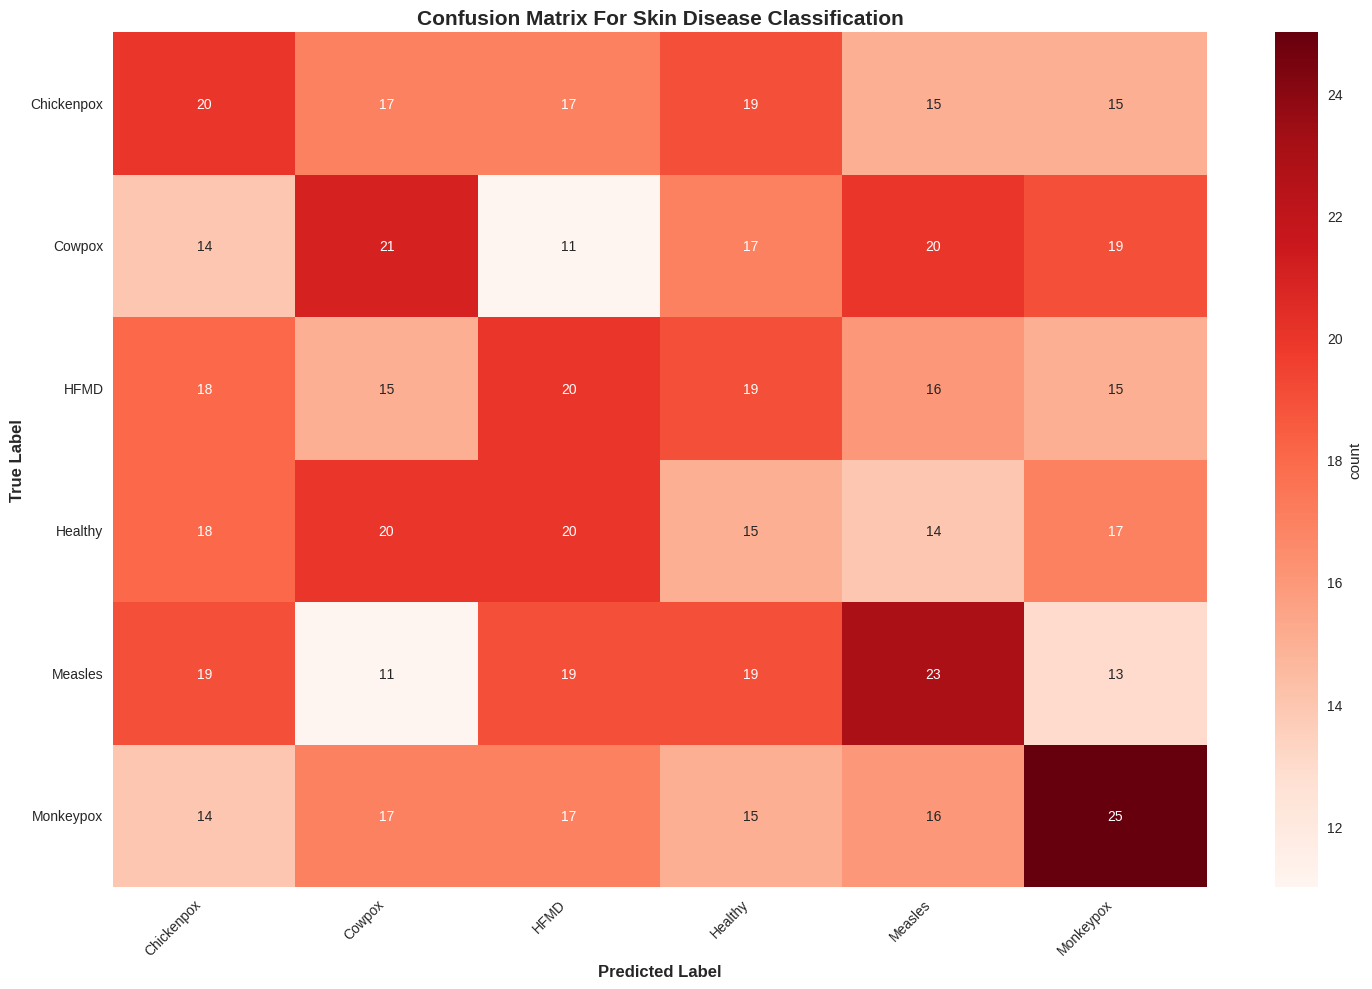


Classification Report
              precision    recall  f1-score   support

  Chickenpox       0.19      0.19      0.19       103
      Cowpox       0.21      0.21      0.21       102
        HFMD       0.19      0.19      0.19       103
     Healthy       0.14      0.14      0.14       104
     Measles       0.22      0.22      0.22       104
   Monkeypox       0.24      0.24      0.24       104

    accuracy                           0.20       620
   macro avg       0.20      0.20      0.20       620
weighted avg       0.20      0.20      0.20       620



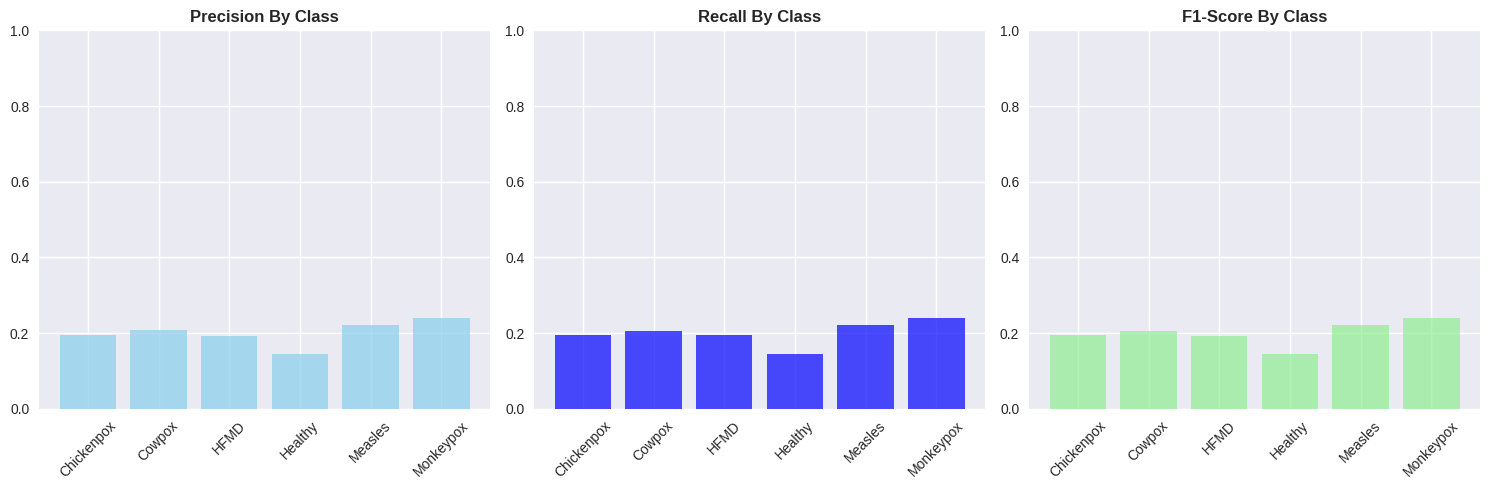


Macro F1-Score: [0.2000]
Weighted F1-Score: [0.2000]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipykernel_35/1440102124.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


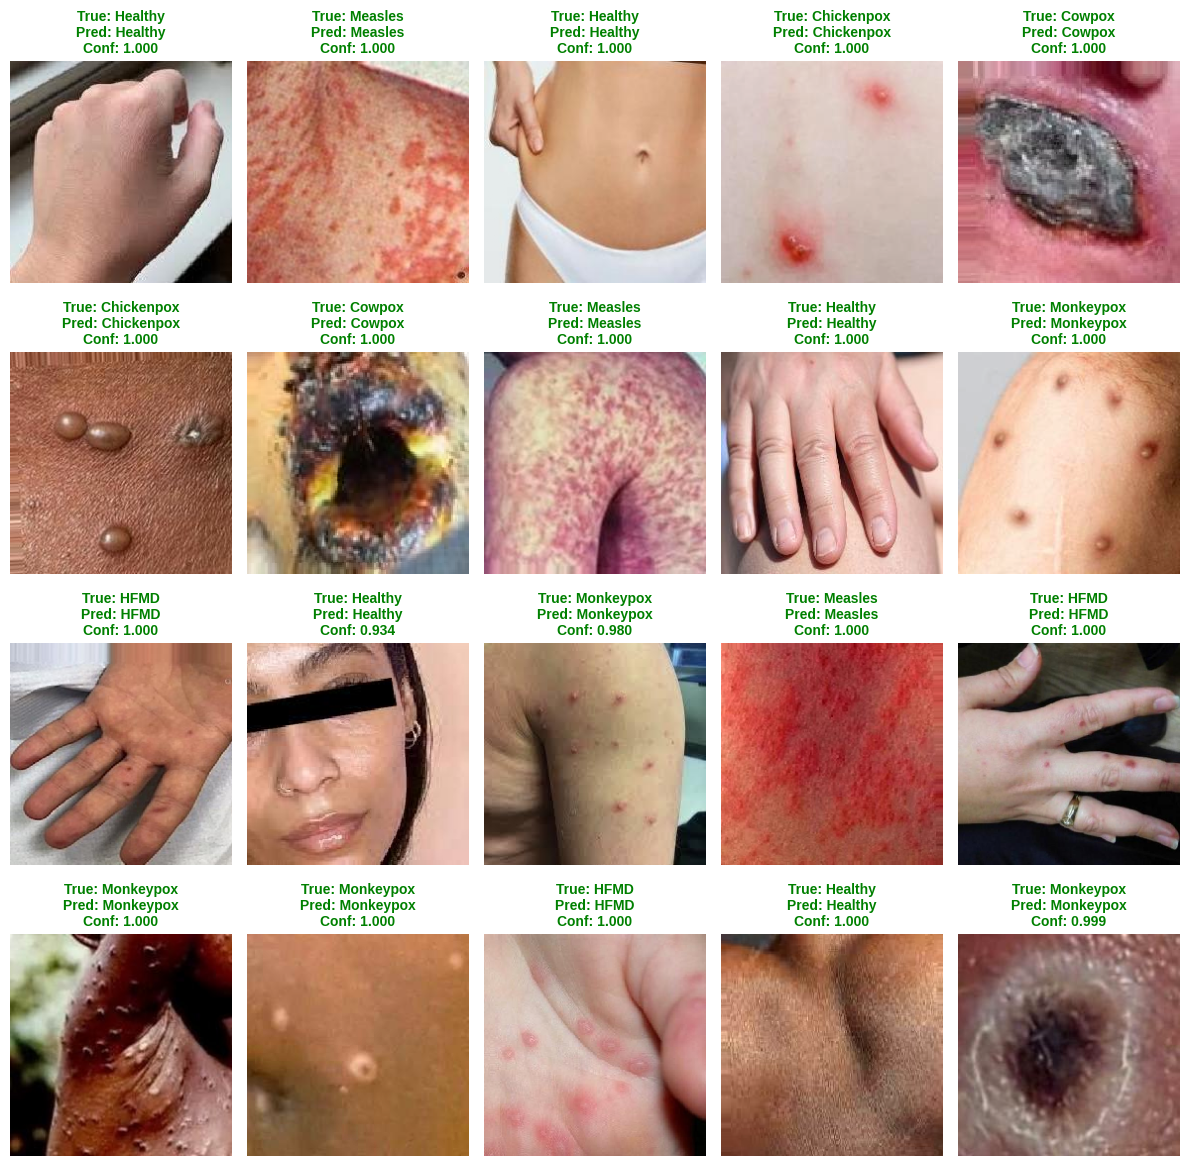

Accuracy on displayed samples: [1.000] [20/20]


In [25]:
results = load_best_model_and_evaluate(new_model=new_model,
                             final_model_save_path='/kaggle/working/final_fine_tune_best.h5',
                             test_gen=test_gen, 
                             eval_results_save_path='/kaggle/working/', 
                             batch_images=32,
                             samples_results_save_path='/kaggle/working/', 
                             num_samples=20, 
                             no_subplot_x_axes=4,
                             no_subplot_y_axes=5)